Saving Hate_Speech.csv to Hate_Speech.csv
Loaded file: Hate_Speech.csv

Columns found: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']

Sample rows:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...



Dropped 0 rows with invalid labels. Remaining rows: 24783

Label distribution (cleaned):
class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Num labels detected: 3 (should be 3 for Hate/Offensive/Neither)

Train size: 19826   Test size: 4957


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]


Using device: cuda


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class counts (train): [ 1144 15352  3330]
Class weights: [17.33042    1.2914279  5.953754 ]

Starting training...
Epoch 1 Step 200 | avg loss so far: 0.8566 | acc so far: 0.7684
Epoch 1 Step 400 | avg loss so far: 0.7396 | acc so far: 0.8084
Epoch 1 Step 600 | avg loss so far: 0.7024 | acc so far: 0.8224
Epoch 1 Step 800 | avg loss so far: 0.6602 | acc so far: 0.8373
Epoch 1 Step 1000 | avg loss so far: 0.6352 | acc so far: 0.8462
Epoch 1 Step 1200 | avg loss so far: 0.6178 | acc so far: 0.8534
Epoch 1/3 -> Avg Loss: 0.6160 | Train Acc: 0.8547
Epoch 2 Step 200 | avg loss so far: 0.5351 | acc so far: 0.8956
Epoch 2 Step 400 | avg loss so far: 0.5018 | acc so far: 0.8973
Epoch 2 Step 600 | avg loss so far: 0.4991 | acc so far: 0.9014
Epoch 2 Step 800 | avg loss so far: 0.5038 | acc so far: 0.9035
Epoch 2 Step 1000 | avg loss so far: 0.5079 | acc so far: 0.9041
Epoch 2 Step 1200 | avg loss so far: 0.5166 | acc so far: 0.9034
Epoch 2/3 -> Avg Loss: 0.5134 | Train Acc: 0.9030
Epoch 3 Step 

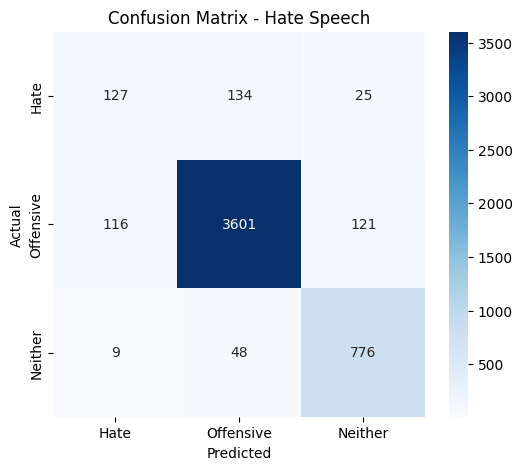

In [ ]:
# =======================
# Hate Speech Training
# =======================
import gc
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# -------- 1) Upload & load file ----------
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print("Loaded file:", file_name)

# read csv
df = pd.read_csv(file_name)

print("\nColumns found:", df.columns.tolist())
print("\nSample rows:")
display(df.head())

# -------- 2) Clean labels (KEEP ONLY 0,1,2) ----------
# Your dataset columns include: ['Unnamed: 0','count','hate_speech','offensive_language','neither','class','tweet']
# Text = 'tweet', Label = 'class' (expected numeric 0/1/2)
if "tweet" not in df.columns or "class" not in df.columns:
    raise ValueError("Expected columns 'tweet' and 'class' not found. Check the CSV header.")

# Drop rows where tweet is null
df = df.dropna(subset=["tweet"]).reset_index(drop=True)

# Ensure label column numeric if possible
# If class column is not numeric already, attempt to coerce to int (will produce NaN for invalid)
df["class"] = pd.to_numeric(df["class"], errors="coerce")

# Keep only labels 0,1,2
valid_labels = [0, 1, 2]
before = len(df)
df = df[df["class"].isin(valid_labels)].copy().reset_index(drop=True)
after = len(df)
print(f"\nDropped {before-after} rows with invalid labels. Remaining rows: {after}")

print("\nLabel distribution (cleaned):")
print(df["class"].value_counts())

# Final safety check
if df["class"].isnull().any():
    raise ValueError("There are still NaN labels after cleaning. Abort.")

# -------- 3) Prepare text and labels ----------
texts = df["tweet"].astype(str)
labels = df["class"].astype(int)

num_labels = int(labels.nunique())
print(f"\nNum labels detected: {num_labels} (should be 3 for Hate/Offensive/Neither)")

# Map label indices -> names for prints
label_names = {0: "Hate", 1: "Offensive", 2: "Neither"}
detected_names = [label_names.get(i, str(i)) for i in sorted(labels.unique())]

# -------- 4) Train-test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
print("\nTrain size:", len(X_train), "  Test size:", len(X_test))

# -------- 5) Tokenizer & Dataset ----------
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].flatten(),
            "attention_mask": enc["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = TweetDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = TweetDataset(X_test, y_test, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# -------- 6) Device & GPU safety: clear caches ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)

# Clean up any leftover GPU memory from previous runs
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# -------- 7) Model creation (create on CPU first, then move to device) ----------
# Create model on CPU to avoid strange device-side asserts at .to(device)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=num_labels
)

# Move to device inside try/except so we can show helpful debug info if it fails
try:
    model.to(device)
except Exception as e:
    # Try a safer move: convert to float then move
    print("Error moving model to device — retrying more safely. Error:", repr(e))
    model = model.cpu()
    if device.type == "cuda":
        # attempt a forced empty cache and move
        gc.collect()
        torch.cuda.empty_cache()
        model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# -------- 8) Class weights (handle imbalance) ----------
y_train_arr = np.array(y_train.astype(int))
class_counts = np.bincount(y_train_arr, minlength=num_labels)
total = len(y_train_arr)
# avoid division by zero
weights = [total / c if c > 0 else 0.0 for c in class_counts]
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("\nClass counts (train):", class_counts)
print("Class weights:", class_weights.cpu().numpy())

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# -------- 9) Training loop (safe) ----------
epochs = 3
print("\nStarting training...")

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total_samples = 0

    for step, batch in enumerate(train_loader, start=1):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["labels"].to(device)

        optimizer.zero_grad()

        # Get logits (no labels passed so we can use weighted loss)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # shape [B, num_labels]

        loss = loss_fn(logits, labels_batch)
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels_batch).sum().item()
        total_samples += labels_batch.size(0)

        if step % 200 == 0:
            print(f"Epoch {epoch} Step {step} | avg loss so far: {epoch_loss/total_samples:.4f} | acc so far: {correct/total_samples:.4f}")

    avg_loss = epoch_loss / total_samples
    acc = correct / total_samples
    print(f"Epoch {epoch}/{epochs} -> Avg Loss: {avg_loss:.4f} | Train Acc: {acc:.4f}")

# -------- 10) Evaluation ----------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=4, target_names=[label_names[i] for i in sorted(label_names.keys())]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[label_names[i] for i in sorted(label_names.keys())],
            yticklabels=[label_names[i] for i in sorted(label_names.keys())])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hate Speech")
plt.show()
